In [1]:
# Primerament importem totes les llibreries necessaries per completar el projecte.
import os
import pandas as pd
import requests
import argparse
import csv
import pathlib 
import time
from datetime import datetime
from bs4 import BeautifulSoup
import json

In [2]:
# Carreguem el fitxer de configuració a la variable config:
with open("configuration.json", "r") as configFile:
    config = json.load(configFile)

In [3]:
# Funcions per obtindre la llista del indexs del Ibex 35 de la borsa de Barcelona

# Get Header
def getHeaders():   
    return config['header']


# Get table Page        
def getPageTable():        
    table = None
    try:
        # Data for post form    
        data = {'punto':'indice'}
        page = requests.post(config['URLs']['base'] + config['URLs']['ref'],timeout=10)
        soup = BeautifulSoup(page.text, "html.parser")
        table = soup.find('table', attrs={'id': 'ctl00_Contenido_tblAcciones'})
    except requests.exceptions.Timeout:
        print("Timeout a la càrrega de la web")
    except:        
        print("Error inesperat")
    return table        

# Get Firm page and wait x seconds
def getFirmTablePage(UrlFirmPage):    
    table = None    
    try:
        t0 = time.time()
        # Data for post form            
        data = {'punto':'indice'}    
        page = requests.get(UrlFirmPage,timeout=10)                    
        soup = BeautifulSoup(page.text, "html.parser")                
        table = soup.find('table', attrs={'id': 'ctl00_Contenido_tblCapital'})                           
        # Wait time depending of response
        response_delay = time.time() - t0     
        time.sleep(10 * response_delay)
    except requests.exceptions.Timeout:
        print("-->Timeout a la càrrega de dada de la companyia")                
    except:                
        print("-->Error inesperat: " +  UrlFirmPage)
    return table

# Get the list of firm interesting values
def getFirmValue(firmPage): 
    value = None
    table = getFirmTablePage(config['URLs']['base']+firmPage)        
    if (table is not None):                
        nroFila=0
        rowNum=0
        for row in table.find_all("tr"):
            if rowNum==1:
                colNum=0                
                for cell in row.find_all('td'):
                    if colNum==1:
                        value = cell.text                                     
                        break;
                    colNum=colNum+1
            rowNum=rowNum+1       
    return value

# Get List with column page names
def getColNames():
    colList = []
    table = getPageTable()
    for tr in table.find_all("tr"):      
        # Cells Header
        cellsHead = tr.findAll('th')                
        if ((cellsHead is not None) and (len(cellsHead) > 0)):
            for cellHead in cellsHead:   
                colList.append(cellHead.text.strip())
    colList.append('Capitalización')
    return colList


# Get a pandas dataframe with table page values
def getDataframe():
    # Obtenció de la taula trobada a la pàgina web amb els valros a extreure
    table = getPageTable()    
    # Obtenció dels noms de totes els columnes
    colList = getColNames()
    # variable on es gaurdaran els valors de cada columna
    totalValues = []
    
    # Per cada fila de la taula
    for tr in table.find_all("tr"):              
        # Es busquen les capçaleres de les columnes
        cellsHead = tr.findAll('th')   
        # En cas de no tractar-se d'una capçalera:             
        if ((cellsHead is None) or (len(cellsHead) == 0)):
            # Es busquen totes les cel·les amb valors
            cells = tr.findAll('td')
            companyValues = []
            # Per cada cel·la amb valors, s'afegeix el valor a la llista de companyValues
            capitalization = None
            for cell in cells:
                a = cell.find('a')                  
                if (a is not None):                 
                    href = a.get('href')
                    if href[0] != '/':
                        href = '/' + href
                    capitalization = getFirmValue(href) 
                companyValues.append(cell.text.strip())
            companyValues.append(capitalization)
            # Després d'obtenir tots els valors, els guardo a la llista totalValues fent que finalment
            # a la variable totalValues es tingui una llista de valors per a cada fila de la taula que no sigui capçalera
            totalValues.append(companyValues)
    
    # Genero un diccionari on la clau és cadascún dels noms de la capçalera de la taula i el valor una llista buida
    dicValues = {}
    for colName in colList:
        dicValues[colName] = []

    # Genero un dataframe amb les capçaleres de la taula com columnes usant el diccionari creat
    dataframe = pd.DataFrame(data=dicValues)
    # Per cada fila de la taula en format llista:
    for list_row in totalValues:
        row = {}
        index = 0
        # Per cada columna (capçalera de la taula), afegeixo al diccionari row el nom de la
        # capçalera com a key i el valor de la llista_row pertinent com a value.
        for colName in colList:
            row[colName] = list_row[index]
            index += 1
        # Afegeixo el diccionari row com a una nova fila del dataframe
        dataframe = dataframe.append(row, ignore_index=True)
    # Finalment, retorno el dataframe
    return dataframe 


# Funció que transforma un dataframe de pandas en un fitxer CSV
def writeCSV(dataframe, fileName):
    # Converteixo el dataframe en format CSV i mostro per pantalla el nom del CSV generat
    dataframe.to_csv(fileName, index = False, header=True)
    print('New CSV file generated: ' + fileName)


# Funció que genera fitxers CSV amb les dades de la web cada 15 minuts fins que es tanca el mercat
def ScheduleDayFile():
    # En cas de que el mercat no estigui tancat:
    while not markedClosed():
        # Adquisició del dataframe, generació del nom que tindrà el fitxer CSV i generació d'aquest
        # amb la funció wreiteCSV.
        dataframe = getDataframe()
        fileName = "ListaIndices" + time.strftime('%Y-%m-%d_%H-%M')+ ".csv"
        writeCSV(dataframe, fileName)
        # Un cop creat i guardat el fixter CSV, ens esperem 15 minuts fins tronar a comprobar l'estat del mercat
        print("Waiting 15 minutes")
        time.sleep(60*15)
    # En cas que el mercat estigui tancat generem n últim CSV.
    dataframe = getDataframe()
    fileName = "ListaIndices" + time.strftime('%Y-%m-%d_%H-%M')+ ".csv"
    writeCSV(dataframe, fileName)
    print("End of session: file generated: " + fileName)


# Retorna un boolean indcant si el mercat està tancat o no
def markedClosed():
    return (getDataframe()['Hora'].iloc[0] == 'Cierre')

    
# Save the Stock Exchange one week
def ScheduleWeekFiles():    
    scheduler = BlockingScheduler()    
    scheduler.add_job(job_function, 'cron', day_of_week='mon-fri', hour=9, minute=0)    
    scheduler.start()    
    

# Retorna un dataframe amb els noms de les empreses que formen part de l'Ibex 35 i de les quals tenim dades
def getIndex():
    return getDataframe()['Nombre']
    

In [4]:
print(getColNames())

['Nombre', 'Últ.', '% Dif.', 'Máx.', 'Mín.', 'Volumen', 'Efectivo (miles €)', 'Fecha', 'Hora', 'Capitalización']


In [5]:
print(list(getIndex()))

['ACCIONA', 'ACERINOX', 'ACS', 'AENA', 'ALMIRALL', 'AMADEUS', 'ARCELORMIT.', 'B.SANTANDER', 'BA.SABADELL', 'BANKINTER', 'BBVA', 'CAIXABANK', 'CELLNEX', 'CIE AUTOMOT.', 'ENAGAS', 'ENDESA', 'FERROVIAL', 'FLUIDRA', 'GRIFOLS CL.A', 'IAG', 'IBERDROLA', 'INDITEX', 'INDRA A', 'INM.COLONIAL', 'MAPFRE', 'MELIA HOTELS', 'MERLIN', 'NATURGY', 'PHARMA MAR', 'R.E.C.', 'REPSOL', 'SIEMENS GAME', 'SOLARIA', 'TELEFONICA', 'VISCOFAN']


In [7]:
 # Crida de la funció per a anar extraient les dades d'interès i anar-les guardant en fitxers CSV
 ScheduleDayFile()

End of session: file generated: ListaIndices2021-04-09_19-48.csv


In [2]:
# Importewm la llibreria glob i matplotlib per poder fer gràfics
import glob
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Definim el directori on hi ha els CSVs
os.chdir("./csv")
# Guardem els noms de tots els CSVs en la llista all_filenames
all_filenames = [i for i in glob.glob('*.csv')]
print(all_filenames)

['finalDatset.csv', 'ListaIndices2021-04-09_09-57.csv', 'ListaIndices2021-04-09_10-14.csv', 'ListaIndices2021-04-09_10-32.csv', 'ListaIndices2021-04-09_10-49.csv', 'ListaIndices2021-04-09_11-06.csv', 'ListaIndices2021-04-09_11-24.csv', 'ListaIndices2021-04-09_11-41.csv', 'ListaIndices2021-04-09_11-58.csv', 'ListaIndices2021-04-09_12-16.csv', 'ListaIndices2021-04-09_12-33.csv', 'ListaIndices2021-04-09_12-50.csv', 'ListaIndices2021-04-09_13-08.csv', 'ListaIndices2021-04-09_13-25.csv', 'ListaIndices2021-04-09_13-42.csv', 'ListaIndices2021-04-09_14-00.csv', 'ListaIndices2021-04-09_14-17.csv', 'ListaIndices2021-04-09_14-34.csv', 'ListaIndices2021-04-09_14-52.csv', 'ListaIndices2021-04-09_15-09.csv', 'ListaIndices2021-04-09_15-26.csv', 'ListaIndices2021-04-09_15-43.csv', 'ListaIndices2021-04-09_16-01.csv', 'ListaIndices2021-04-09_16-18.csv', 'ListaIndices2021-04-09_16-36.csv', 'ListaIndices2021-04-09_16-53.csv', 'ListaIndices2021-04-09_17-10.csv', 'ListaIndices2021-04-09_17-28.csv', 'ListaIn

In [16]:
# Combinem tots els fitxers de la llista anterior en un nou dataframe
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
# Convertim el dataframe en un fitxer CSV nomenat finalDataset.csv
combined_csv.to_csv( "finalDatset.csv", index=False, encoding='utf-8-sig')

# S'han de convertir a numèriques les diferents columnes tractades com a text
# Primer eliminem tots els punts i, després, substituim totes les commes per punts:
combined_csv = combined_csv.apply(lambda x: x.str.replace('.',''))
combined_csv = combined_csv.apply(lambda x: x.str.replace(',','.'))

<ipython-input-16-fd101d5421e6>:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  combined_csv = combined_csv.apply(lambda x: x.str.replace('.',''))


In [17]:
# Convertim totes les columnes en números:
combined_csv['Últ.'] = combined_csv['Últ.'].astype(float)
combined_csv['% Dif.'] = combined_csv['% Dif.'].astype(float)
combined_csv['Máx.'] = combined_csv['Máx.'].astype(float)
combined_csv['Mín.'] = combined_csv['Mín.'].astype(float)
combined_csv['Volumem'] = combined_csv['Volumen'].astype(int)
combined_csv['Efectivo (miles €)'] = combined_csv['Efectivo (miles €)'].astype(float)
combined_csv['Capitalización'] = combined_csv['Capitalización'].astype(float)

In [42]:
# Obtenció d'una descripció estadistica genèrica del dataset
combined_csv.describe()

,Últ.,% Dif.,Máx.,Mín.,Efectivo (miles €),Capitalización,Volumem
count,17850.000000,17850.000000,17850.000000,17850.000000,17850.000000,1.783300e+04,1.785000e+04
mean,26.764558,-0.629933,27.056480,26.628415,10259.870619,1.640049e+07,1.824402e+06
std,33.805975,0.985767,34.147178,33.685068,15787.391538,1.924144e+07,4.338276e+06
min,0.453400,-4.300000,0.464400,0.451200,173.970000,1.316075e+06,3.121000e+03
25%,6.512000,-1.000000,6.596000,6.500000,2191.200000,3.054467e+06,9.555900e+04
50%,17.917500,-0.570000,18.635000,17.765000,4861.500000,8.645796e+06,2.798530e+05
75%,27.600000,-0.060000,27.780000,27.540000,10890.890000,2.109991e+07,1.186616e+06
max,141.000000,2.190000,141.200000,139.600000,120117.270000,8.698576e+07,3.570338e+07


In [43]:
# Obtenció d'una descripció estadistica del dataset per a cada atribut de cada empresa de l'Ibex 35
groupedDataframe = combined_csv.groupby(['Nombre'])
groupedDataframe.describe().transpose()

Nombre                         ACCIONA      ACERINOX           ACS  \
Últ.               count  5.100000e+02  5.100000e+02  5.100000e+02   
                   mean   1.400833e+02  1.141100e+01  2.765433e+01   
                   std    3.628319e-01  4.089351e-02  6.807085e-02   
                   min    1.395000e+02  1.127500e+01  2.755000e+01   
                   25%    1.398000e+02  1.139500e+01  2.760000e+01   
                   50%    1.400000e+02  1.142000e+01  2.765000e+01   
                   75%    1.403000e+02  1.144000e+01  2.772000e+01   
                   max    1.410000e+02  1.146000e+01  2.776000e+01   
% Dif.             count  5.100000e+02  5.100000e+02  5.100000e+02   
                   mean  -5.093333e-01  1.071333e+00 -6.316667e-01   
                   std    2.572339e-01  3.614615e-01  2.443173e-01   
                   min   -9.200000e-01 -1.300000e-01 -1.010000e+00   
                   25%   -7.100000e-01  9.300000e-01 -8.300000e-01   
                   50%   -5.700000e-01  1.150000e+00 -6.450000e-01   
                   75%   -3.600000e-01  1.330000e+00 -4.000000e-01   
                   max    1.400000e-01  1.510000e+00 -2.500000e-01   
Máx.               count  5.100000e+02  5.100000e+02  5.100000e+02   
                   mean   1.412000e+02  1.144750e+01  2.798000e+01   
                   std    2.844961e-14  4.855450e-02  0.000000e+00   
                   min    1.412000e+02  1.132500e+01  2.798000e+01   
                   25%    1.412000e+02  1.141500e+01  2.798000e+01   
                   50%    1.412000e+02  1.148000e+01  2.798000e+01   
                   75%    1.412000e+02  1.148000e+01  2.798000e+01   
                   max    1.412000e+02  1.148000e+01  2.798000e+01   
Mín.               count  5.100000e+02  5.100000e+02  5.100000e+02   
                   mean   1.394400e+02  1.123500e+01  2.756333e+01   
                   std    8.007855e-02  3.556202e-15  3.621409e-02   
                   min    1.394000e+02  1.123500e+01  2.752000e+01   
                   25%    1.394000e+02  1.123500e+01  2.754000e+01   
                   50%    1.394000e+02  1.123500e+01  2.757000e+01   
                   75%    1.394000e+02  1.123500e+01  2.757000e+01   
                   max    1.396000e+02  1.123500e+01  2.772000e+01   
Efectivo (miles €) count  5.100000e+02  5.100000e+02  5.100000e+02   
                   mean   3.584394e+03  4.274709e+03  6.952126e+03   
                   std    2.201763e+03  1.982134e+03  6.299293e+03   
                   min    4.381600e+02  5.196100e+02  8.874000e+02   
                   25%    1.771380e+03  2.752900e+03  1.946170e+03   
                   50%    3.529545e+03  4.405330e+03  2.822730e+03   
                   75%    5.007520e+03  5.772060e+03  1.275232e+04   
                   max    9.132510e+03  8.255670e+03  2.114809e+04   
Capitalización     count  5.100000e+02  5.100000e+02  5.100000e+02   
                   mean   7.723817e+06  3.054467e+06  8.645796e+06   
                   std    0.000000e+00  0.000000e+00  0.000000e+00   
                   min    7.723817e+06  3.054467e+06  8.645796e+06   
                   25%    7.723817e+06  3.054467e+06  8.645796e+06   
                   50%    7.723817e+06  3.054467e+06  8.645796e+06   
                   75%    7.723817e+06  3.054467e+06  8.645796e+06   
                   max    7.723817e+06  3.054467e+06  8.645796e+06   
Volumem            count  5.100000e+02  5.100000e+02  5.100000e+02   
                   mean   2.557497e+04  3.758502e+05  2.498113e+05   
                   std    1.571478e+04  1.736816e+05  2.262678e+05   
                   min    3.121000e+03  4.602100e+04  3.187900e+04   
                   25%    1.264900e+04  2.428050e+05  7.016000e+04   
                   50%    2.517450e+04  3.873505e+05  1.017755e+05   
                   75%    3.572000e+04  5.070070e+05  4.574630e+05   
                   max    6.519900e+04  7.245290e+05  7.615260e+05   

Nombre   

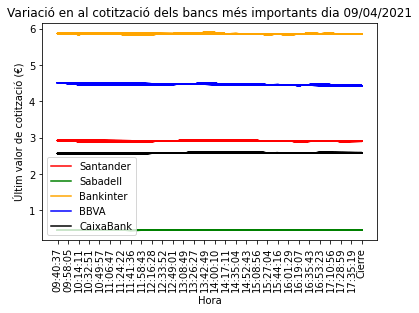

In [44]:
# Amb aquest dataframe es poden fer mil gràfiques i extreure moltes conclussions però com tampoc és l'objectiu de l'assginatura
# hem decidit comparar els principals bancs d'Espanya per veure les seves diferències pel que fa a la variació diària de la seva cotització.
# Primerament filtro el datset per generar 5 nous datasets amb les dades dels bancs d'interés
santander = combined_csv[combined_csv['Nombre']=='BSANTANDER']
sabadell = combined_csv.loc[combined_csv['Nombre']=='BASABADELL']
bankinter = combined_csv.loc[combined_csv['Nombre']=='BANKINTER']
bbva = combined_csv.loc[combined_csv['Nombre']=='BBVA']
caixabank = combined_csv.loc[combined_csv['Nombre']=='CAIXABANK']

# Definim un eix x amb la data i 5 eixos y on, cada eix y representa el valor de la última dada decotització de cada banc.
x = caixabank['Hora']
y1 = santander['Últ.']
y2 = sabadell['Últ.']
y3 = bankinter['Últ.']
y4 = bbva['Últ.']
y5 = caixabank['Últ.']

# Agreguem al mateix grafic de linies tots els eixos y
plt.plot(x,y1 , label = "Santander", color = "red")
plt.plot(x,y2 , label = "Sabadell", color ="green")
plt.plot(x,y3 , label = "Bankinter", color ="orange")
plt.plot(x,y4 , label = "BBVA", color ="blue")
plt.plot(x,y5 , label = "CaixaBank", color ="black")

# Rotem els tics de l'eix x 90º per a una millor visualització.
plt.xticks(rotation=90)

# Definim els tituls dels eixos i gràfic, creem la llegenda i, finalment, msotrem el gràfic geenrat.
plt.xlabel('Hora')
plt.ylabel('Últim valor de cotització (€)')
plt.title('Variació en al cotització dels bancs més importants dia 09/04/2021')
plt.legend()
plt.show()

Text(1.0, 1.0, 'CaixaBank')

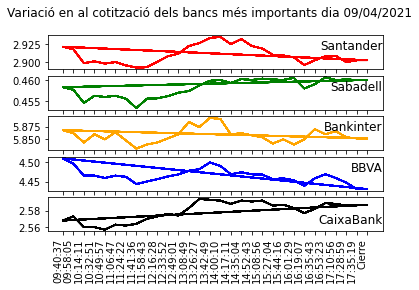

In [53]:
#Finalment, generem un gràfic que contingui 5 gràfics de linies mostrant la variació en al cotització dels bancs més importants
fig, axs = plt.subplots(5, sharex=True)
fig.suptitle('Variació en al cotització dels bancs més importants dia 09/04/2021')
fig.autofmt_xdate(rotation=90)

axs[0].plot(x,y1, color = "red")
axs[0].set_title("Santander", y=1.0, pad=-14, loc='right')
axs[1].plot(x,y2, color ="green")
axs[1].set_title("Sabadell", y=1.0, pad=-14, loc='right')
axs[2].plot(x,y3, color ="orange")
axs[2].set_title("Bankinter", y=1.0, pad=-14, loc='right')
axs[3].plot(x,y4, color ="blue")
axs[3].set_title("BBVA", y=1.0, pad=-14, loc='right')
axs[4].plot(x,y5, color ="black")
axs[4].set_title("CaixaBank", y=1.0, pad=-26, loc='right')